In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import os
import matplotlib.pyplot as plt
from rms import getRmsResults, getDetaliedRMSResult
from cpt import get_cpt_results
from asrs import getAsrsResults
from survey import getSurveyResultsByTrialIndex
import json
from sklearn.linear_model import LinearRegression
from analysis import getCorrTable, plot_multiple_two_columns_with_regression_line

# Data Clean

## Frodo

In [2]:
frodo_subjects = []

In [3]:
directory = os.fsencode(os.path.join(os.getcwd(), 'data/frodo'))
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):
        currnet_subject = pd.read_csv('data/frodo/' + filename)
        frodo_subjects.append(currnet_subject)

In [4]:
def get_frodo_results_df(df_list):
    results = pd.DataFrame()
    for df in df_list:
        if df[(df.name == "ASRS_1_0")].shape[0] == 0:
            continue
        brms_rt_mean, brms_rt_std, rms_errors_percent, rms_face_invertion_effect, \
            control_brms_rt_mean, control_brms_rt_std, control_rms_errors_percent, \
            control_rms_face_invertion_effect = getDetaliedRMSResult(df, control_exist=True)
        if rms_errors_percent > 0.15:
            print("badBoy_RMS", rms_errors_percent)
            continue
       
        cpt_rt_mean, cpt_rt_sd, cpt_err = get_cpt_results(df)
        asrs_result = getAsrsResults(df)
        gender, hand, lang = getSurveyResultsByTrialIndex(df, 1)
        age, subject = getSurveyResultsByTrialIndex(df, 2)
        adhd = getSurveyResultsByTrialIndex(df, 3)[0]
        feel_adhd = getSurveyResultsByTrialIndex(df, 4)[0]
        subject_result = {
            'feel_adhd': feel_adhd,
            'gender': gender,
            'age': age,
            'strong_hand': hand,
            'adhd': adhd,
            'main_language': lang,
            "brms_rt_mean": brms_rt_mean,
            "brms_rt_std": brms_rt_std,
            "brms_icv": brms_rt_std / brms_rt_mean,
            "rms_errors_percent": rms_errors_percent,
            "rms_face_invertion_effect": rms_face_invertion_effect,
            "control_brms_rt_mean": control_brms_rt_mean,
            "control_brms_rt_std": control_brms_rt_std,
            "control_rms_errors_percent": control_rms_errors_percent,
            "control_rms_face_invertion_effect": control_rms_face_invertion_effect,
            "cpt_rt_mean": cpt_rt_mean,
            "cpt_rt_sd": cpt_rt_sd,
            "cpt_errors": cpt_err,
            "cpt_icv": cpt_rt_sd / cpt_rt_mean,
            "asrs_result": asrs_result[0] + asrs_result[1],
            "asrs_1_count": asrs_result[0],
            "asrs_2_count": asrs_result[1],
        }
        results = pd.concat([results, pd.DataFrame([subject_result])], ignore_index=True)

    return results


In [5]:
frodo_results_df = get_frodo_results_df(frodo_subjects)
frodo_results_df.shape

badBoy_RMS 0.16129032258064516


(49, 22)

## Bilbo 2

In [6]:
bilbo_2_subjects = []

In [7]:
def get_asrs_data(single_df):
    asrs_df = single_df[(single_df.block == 'ASRS')]

    asrs_1 = 0
    asrs_2 = 0
    asrs_count = 0
    if (not "name" in single_df.columns) or (single_df[(single_df.name == 'ASRS_3')].shape[0] == 0):
        for index, row in asrs_df.iterrows():
            asrs_obj = json.loads(row['responses'])
            asrs_count += asrs_obj.get('Q0') + \
                asrs_obj.get('Q1') + asrs_obj.get('Q2')
        asrs_1, asrs_2 = None, None
    else:
        for i in range(0, 18, 3):
            asrs_test = single_df[(single_df.name == 'ASRS_' + str(i))]
            obj = json.loads(asrs_test['responses'].iloc[0])
            if i > 3:
                asrs_1 += obj.get('Q0') + obj.get('Q1') + obj.get('Q2')
            else:
                asrs_2 += obj.get('Q0') + obj.get('Q1') + obj.get('Q2')
        asrs_count = asrs_1 + asrs_2

    return asrs_1, asrs_2, asrs_count


In [8]:
def get_bilbo_2_results_df(df_list):
    results = pd.DataFrame()
    for df in df_list:
        brms_rt_mean, brms_rt_std, rms_errors_percent, rms_face_inversion_effect = getDetaliedRMSResult(df)
        if rms_errors_percent > 0.15:
            print("badBoy_RMS", rms_errors_percent)
            continue
        cpt_rt_mean, cpt_rt_sd, cpt_err = get_cpt_results(df)
        cpt_err = cpt_err / 320
        asrs_result = get_asrs_data(df)
        gender, hand, lang = getSurveyResultsByTrialIndex(df, 1)
        age = getSurveyResultsByTrialIndex(df, 2)
        adhd = getSurveyResultsByTrialIndex(df, 3)[0]
        feel_adhd = getSurveyResultsByTrialIndex(df, 4)[0]
        subject_result = {
            'feel_adhd': feel_adhd,
            'gender': gender,
            'age': age,
            'strong_hand': hand,
            'rms_face_inversion_effect': rms_face_inversion_effect,
            'adhd': adhd,
            'main_language': lang,
            "brms_rt_mean": brms_rt_mean,
            "brms_rt_std": brms_rt_std,
            "brms_icv": brms_rt_std / brms_rt_mean,
            "rms_errors_percent": rms_errors_percent,
            "cpt_rt_mean": cpt_rt_mean,
            "cpt_rt_sd": cpt_rt_sd,
            "cpt_errors": cpt_err,
            "cpt_icv": cpt_rt_sd / cpt_rt_mean,
            "asrs_result": asrs_result[2],
            "asrs_1_count": asrs_result[0],
            "asrs_2_count": asrs_result[1],
        }
        results = pd.concat([results, pd.DataFrame([subject_result])], ignore_index=True)
    return results

In [9]:
for file in os.listdir(os.fsencode('data/bilbo2/')):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):
        bilbo_2_subjects.append(pd.read_csv('data/bilbo2/' + filename))

In [10]:
bilbo_2_results_df = get_bilbo_2_results_df(bilbo_2_subjects)
bilbo_2_results_df.shape

badBoy_RMS 0.5675675675675675
badBoy_RMS 0.5901639344262295
badBoy_RMS 0.375
badBoy_RMS 0.4666666666666667
badBoy_RMS 0.5081967213114754
badBoy_RMS 0.39655172413793105
badBoy_RMS 1


(21, 18)

In [11]:
#TODO: Remove and use frodo's function
def get_new_cpt_result(single_df, standard = True):
    cpt_df = single_df[(single_df.trial_type == 'image-cpt') & (single_df.stimulus_block != 'training')]
    error_count_1 = cpt_df[(cpt_df.is_stimulus == False) & (cpt_df.key_press == '32')].shape[0]
    error_count_2 = cpt_df[(cpt_df.is_stimulus == True) & (cpt_df.key_press != '32')].shape[0]
    error_count = error_count_1 + error_count_2
    rt = cpt_df[(cpt_df.is_stimulus == True) & (cpt_df.key_press == '32')].rt.mean()
    std = cpt_df[(cpt_df.is_stimulus == True) & (cpt_df.key_press == '32')].rt.std()
    if standard:
        cpt_df = cpt_df[(cpt_df.is_stimulus == True) & (cpt_df.key_press == '32')]
        cpt_df = cpt_df[(cpt_df.rt > (rt - (2 * std))) & (cpt_df.rt < (rt + (2 * std)))]
        rt = cpt_df.rt.mean()
        std = cpt_df.rt.std()
    return rt, std, error_count

## Bilbo 1

# Analysis

In [12]:
final_df = pd.concat([frodo_results_df, bilbo_2_results_df])

## Bilbo 2 and frodo corr table

In [13]:
getCorrTable(final_df)

,brms_rt_mean,brms_rt_std,brms_icv,rms_errors_percent,rms_face_invertion_effect,control_brms_rt_mean,control_brms_rt_std,control_rms_errors_percent,cpt_rt_mean,cpt_rt_sd,cpt_errors,cpt_icv,asrs_result,rms_face_inversion_effect
brms_rt_mean,1.0***,0.95***,0.75***,-0.26***,0.38***,0.74***,0.67***,-0.15,0.31***,0.29***,-0.09,0.16,0.08,-0.18
brms_rt_std,0.95***,1.0***,0.87***,-0.25***,0.52***,0.75***,0.74***,-0.11,0.37***,0.37***,-0.09,0.23**,0.05,-0.08
brms_icv,0.75***,0.87***,1.0***,-0.27***,0.46***,0.54***,0.57***,-0.12,0.35***,0.36***,-0.1,0.27***,0.04,0.27
rms_errors_percent,-0.26***,-0.25***,-0.27***,1.0***,-0.2,-0.24**,-0.26**,0.35***,-0.1,0.07,-0.06,0.14,0.03,-0.0
rms_face_invertion_effect,0.38***,0.52***,0.46***,-0.2,1.0***,0.25**,0.35***,-0.08,0.57***,0.51***,-0.05,0.32***,-0.02,nan
control_brms_rt_mean,0.74***,0.75***,0.54***,-0.24**,0.25**,1.0***,0.95***,-0.14,0.44***,0.5***,0.03,0.39***,0.09,nan
control_brms_rt_std,0.67***,0.74***,0.57***,-0.26**,0.35***,0.95***,1.0***,-0.07,0.47***,0.54***,-0.01,0.43***,0.08,nan
control_rms_errors_percent,-0.15,-0.11,-0.12,0.35***,-0.08,-0.14,-0.07,1.0***,-0.04,0.03,0.35***,0.03,0.43***,nan
cpt_rt_mean,0.31***,0.37***,0.35***,-0.1,0.57***,0.44***,0.47***,-0.04,1.0***,0.81***,-0.08,0.45***,-0.12,-0.06
cpt_rt_sd,0.29***,0.37***,0.36***,0.07,0.51***,0.5***,0.54***,0.03,0.81***,1.0***,0.04,0.88***,-0.05,-0.17


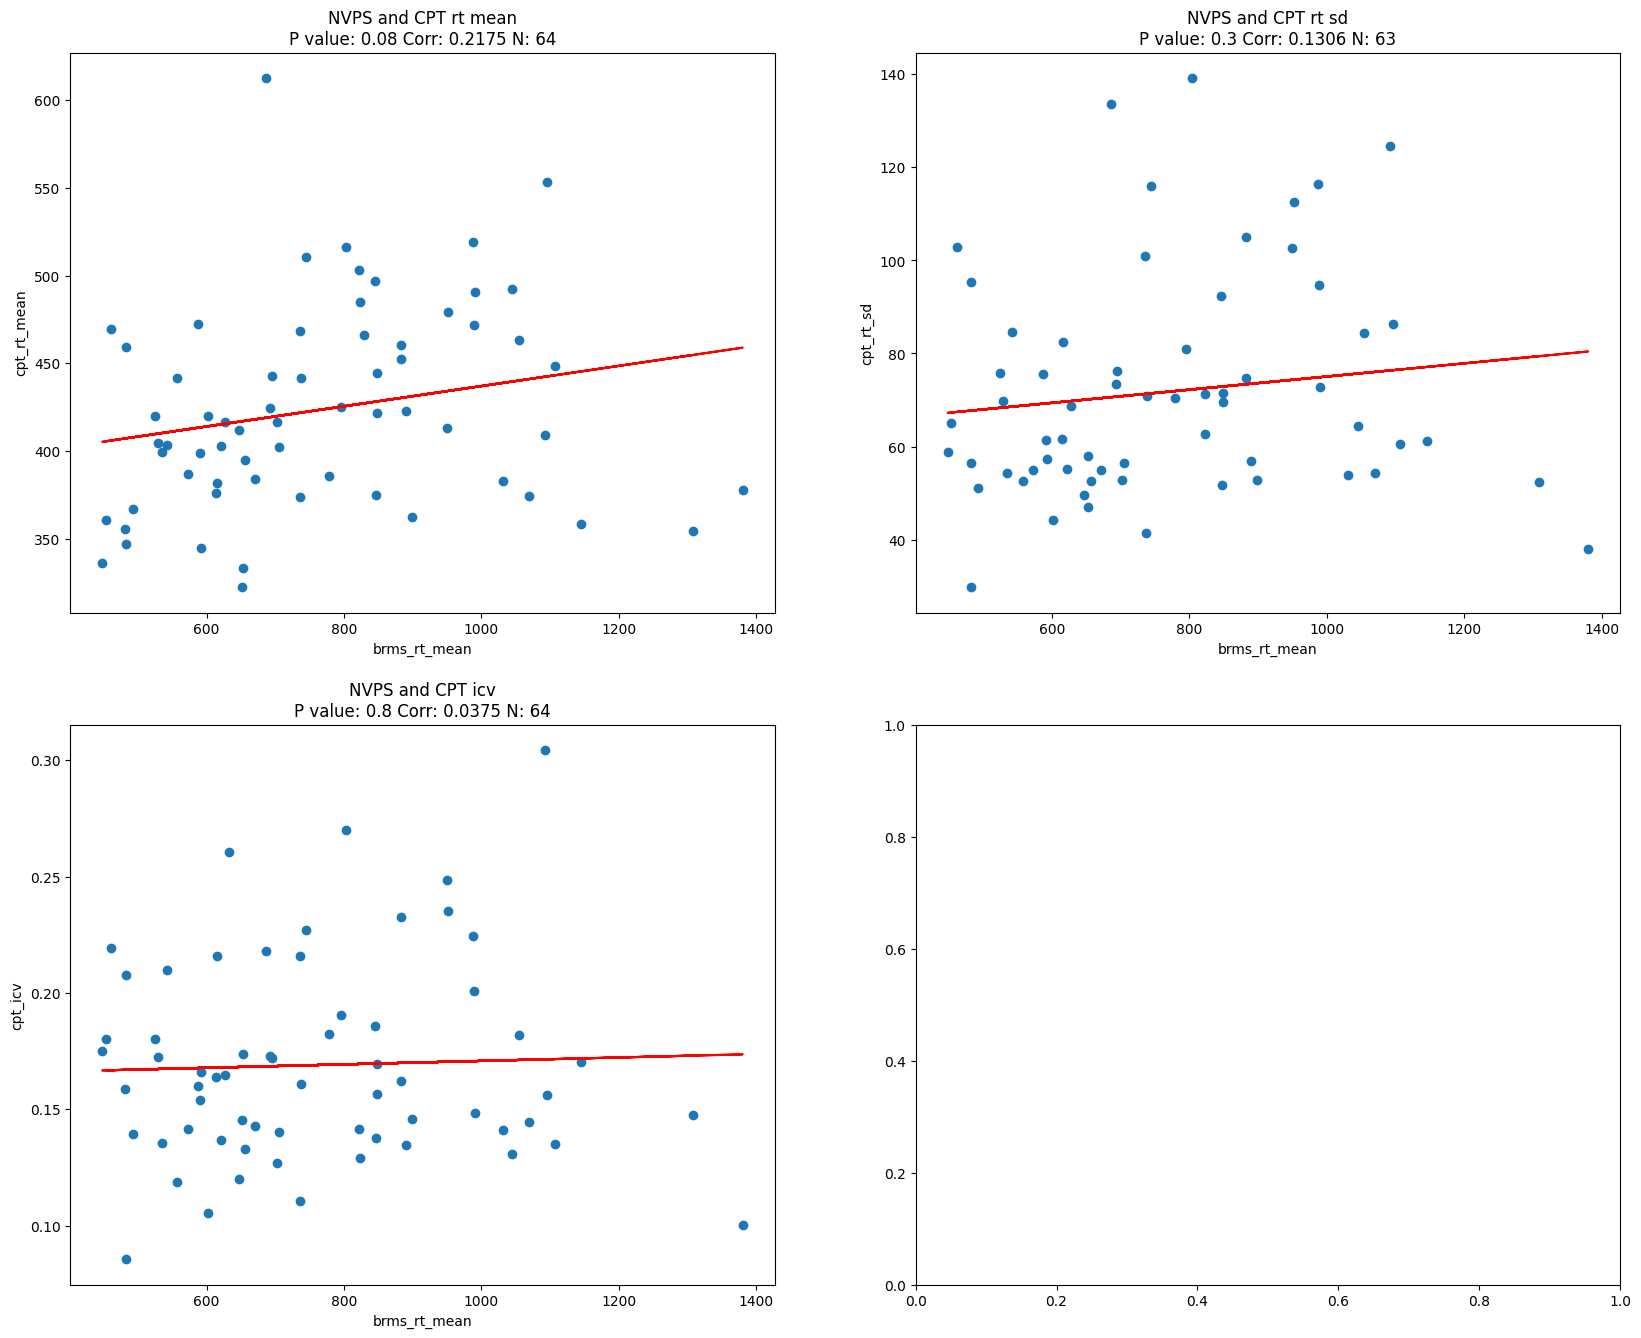

In [20]:
from analysis import plot_two_cols_with_regression_line

plot_multiple_two_columns_with_regression_line([[final_df, "brms_rt_mean", "cpt_rt_mean", True, "NVPS and CPT rt mean"],
                                                [final_df, "brms_rt_mean", "cpt_rt_sd", True, "NVPS and CPT rt sd"],
                                                [final_df, "brms_rt_mean", "cpt_icv", True, "NVPS and CPT icv"]],
                                               in_line=3)
